In [1]:
from __future__ import annotations
import math
import numpy as np
import matplotlib.pyplot as plt

In [49]:
# helper functions for tensor manipulation

def _to_ndarray(x):
    if isinstance(x, Value): return x
    if isinstance(x, (int, float)): return Value(np.array(x, dtype=float))
    if isinstance(x, np.ndarray): return Value(x.astype(float, copy=False))
    raise TypeError(f"Unsupported Operand: {type(x)}")

def _zero_like(x):
    return np.zeros_like(x, dtype=float)


def _unbroadcast(grad, shape):
    """Sum grad along axes that were broadcast in the forward pass to match 'shape'."""
    # If grad has extra leading dims, sum them away
    while grad.ndim > len(shape):
        grad = grad.sum(axis=0)
    # Sum over dims where target shape is 1
    for i, (gdim, sdim) in enumerate(zip(grad.shape, shape)):
        if sdim == 1 and gdim != 1:
            grad = grad.sum(axis=i, keepdims=True)
    return grad

In [64]:
class Value:
    def __init__(self, data: float | np.ndarray, _children=(), _op=''):
        self.data = data 
        self.grad = 0.0
        self._prev = set(_children)
        self._backward = lambda: None

    def __repr__(self):
        return f'Value(data={self.data}, grad={self.grad})'

    def __getitem__(self, idx):
        if idx<0 or idx>len(self.data):
            raise IndexError(f"Row index {idx} out of range; must be in [0, {len(self.val)-1}]")

        return self.data[idx]

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        y = math.tanh(self.data)
        out = Value(y, (self,), 'tanh')

        def _backward():
            self.grad += (1 - y*y) * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)); 'Only accepting int, float'
        out = Value(self.data ** other, (self, ), '**') 
        
        def _backward():
            self.grad += other * (self.data) ** (other - 1) * out.grad

        out._backward = _backward
        return out

    def __matmul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
    
        A = self.data      # assume list of lists or 2D array
        B = other.data
    
        # infer shapes
        n_rows_A = len(A)
        n_cols_A = len(A[0])
        n_rows_B = len(B)
        n_cols_B = len(B[0])
    
        if n_cols_A != n_rows_B:
            raise ValueError(
                f"matmul shape mismatch: {n_rows_A}x{n_cols_A} @ {n_rows_B}x{n_cols_B}"
            )
        
        # allocate result (n_rows_A x n_cols_B)
        res = [[0.0 for _ in range(n_cols_B)] for _ in range(n_rows_A)]
    
        for i in range(n_rows_A):
            for j in range(n_cols_B):
                total = 0.0
                for k in range(n_cols_A):
                    total += A[i][k] * B[k][j]
                res[i][j] = total
    
        out = Value(res, (self, other), '@')
    
        def _backward():
            # dL/dA = dL/dOut @ B^T
            # dL/dB = A^T @ dL/dOut
            # but here out.grad will be matrix-shaped
            raise NotImplementedError("backward for matmul not implemented yet")
    
        out._backward = _backward
        return out

        
    def __neg__(self):
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def backward(self):
        visited = set()
        topo = []

        def build(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build(child)
                topo.append(v)

        build(self)
        self.grad = 1.0
        for x in reversed(topo):
            x._backward()
           

# Testing Value class

In [65]:
a = Value(2)
c = Value(3)
b = Value(4)

d = a * b
f = d + c
f

Value(data=11, grad=0.0)

In [66]:
f.grad = 1

In [67]:
f._backward()
d

Value(data=8, grad=1.0)

In [68]:
d._backward()
d

Value(data=8, grad=1.0)

In [69]:
c._backward()

In [70]:
d._backward()

In [71]:
a._backward()
b._backward()

In [72]:
a,b,c,d,f # checking populations of grads

(Value(data=2, grad=8.0),
 Value(data=4, grad=4.0),
 Value(data=3, grad=1.0),
 Value(data=8, grad=1.0),
 Value(data=11, grad=1))

In [73]:
d._prev

{Value(data=2, grad=8.0), Value(data=4, grad=4.0)}

In [74]:
c = Value(3)
x = c ** 4 
x

Value(data=81, grad=0.0)

In [75]:
x.grad = 1
x._backward()
c._backward()
c

Value(data=3, grad=108.0)

In [76]:
x._prev

{Value(data=3, grad=108.0)}

In [77]:
a = Value(2)
b = Value(4)
c = Value(3)

d = a * b      # 8
f = d + c      # 11

f.backward()   # builds topo, sets f.grad=1, backprops

print(a, b, c) # grads: df/da = 4, df/db = 2, df/dc = 1

Value(data=2, grad=4.0) Value(data=4, grad=2.0) Value(data=3, grad=1.0)


In [78]:
mat1 = Value([[1, 2, 3], [4, 5, 6]]) 
mat2 = Value([[1, 2], [3, 4], [5, 6]])

mat1@mat2

Value(data=[[22.0, 28.0], [49.0, 64.0]], grad=0.0)

# making sure scalar autograd works

In [79]:
# creating dataset
# linear regression 

m = 3.2
b = 5.7

x = np.arange(1.0, 10.0, 0.05)

y = m * x + b

x.shape, y.shape , x[:5], y[:5]

((180,),
 (180,),
 array([1.  , 1.05, 1.1 , 1.15, 1.2 ]),
 array([8.9 , 9.06, 9.22, 9.38, 9.54]))

In [80]:
# train test split
split_size = int(len(x) * 0.8)

X_train, y_train = x[:split_size], y[:split_size]
X_test, y_test = x[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(144, 144, 36, 36)

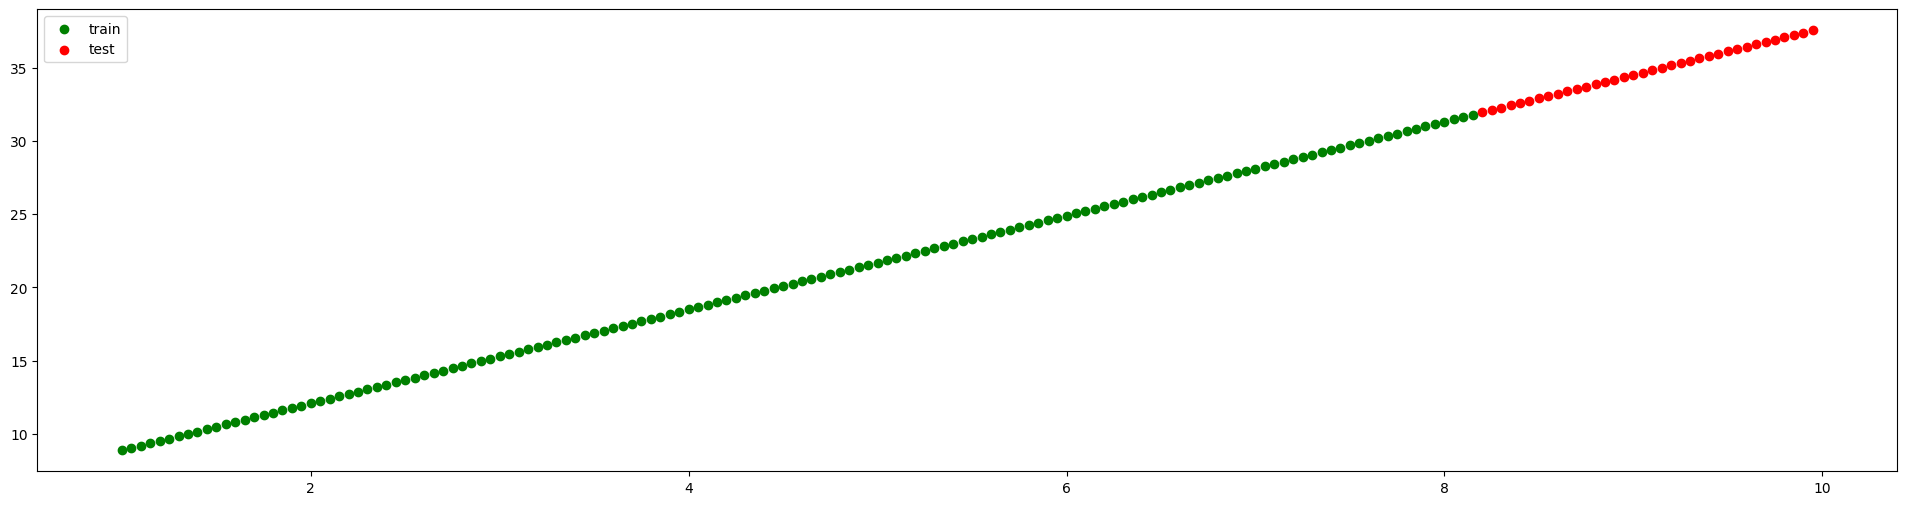

In [81]:
# visualizing the dataset

def plot(train: tuple, test: tuple = None, pred = None):
    X_train, y_train = train[0], train[1]

    if test is not None:
        X_test, y_test = test[0], test[1]

    # plot
    plt.figure(figsize=(24, 6))
    plt.scatter(X_train, y_train, c='g', label='train')
    if test is not None:
        plt.scatter(X_test, y_test, c='r', label='test')
    if pred is not None:
        plt.scatter(X_test, pred, c='y', label='pred')
    plt.legend()
    plt.show()


plot(train=(X_train, y_train), test=(X_test, y_test))

In [82]:
# error function for the regression model

def error(y_train, y_pred):
    # MSE
    error = y_pred - y_train
    return error * error

In [83]:
# model init --  weights and bias
# random
Wi = Value(np.random.randn())
bi = Value(np.random.randn())

print(Wi, bi)

Value(data=1.15381489693114, grad=0.0) Value(data=-1.4227286060494826, grad=0.0)


In [84]:
# training a tiny model on this 
epochs = 1000
N = len(X_train)
lr = 1e-2

for i in range(epochs):

    # zero grads
    Wi.grad = 0.0
    bi.grad = 0.0
    
    # forward pass
    loss = Value(0.0)
    
    for xi, yi in zip(X_train, y_train): # training on the full dataset
        y_pred = Wi * Value(float(xi)) + bi # scalar value
        # loss
        diff = error(Value(float(yi)), y_pred)
        loss += diff

    # avg
    loss = loss * Value(1 / N)
    
    
    # prints
    if i % 100 == 0:
        print(f'epoch: {i} | loss: {round(loss.data, 3)}')
        

    # backprop
    loss.backward()
    
    # gradient descent
    Wi.data -= lr * Wi.grad
    bi.data -= lr * bi.grad


epoch: 0 | loss: 289.81
epoch: 100 | loss: 3.761
epoch: 200 | loss: 1.937
epoch: 300 | loss: 0.998
epoch: 400 | loss: 0.514
epoch: 500 | loss: 0.265
epoch: 600 | loss: 0.136
epoch: 700 | loss: 0.07
epoch: 800 | loss: 0.036
epoch: 900 | loss: 0.019


In [85]:
# test 

y_p = []
test_loss = Value(0.0)
for xi, yi in zip(X_test, y_test):
    y_hat = Wi * Value(float(xi)) + bi
    y_p.append(y_hat.data)
    diff = error(Value(float(yi)), y_hat)
    test_loss += diff

loss_p = test_loss * Value(1.0/ len(X_test))
print(loss_p)

Value(data=0.024552963405162564, grad=0.0)


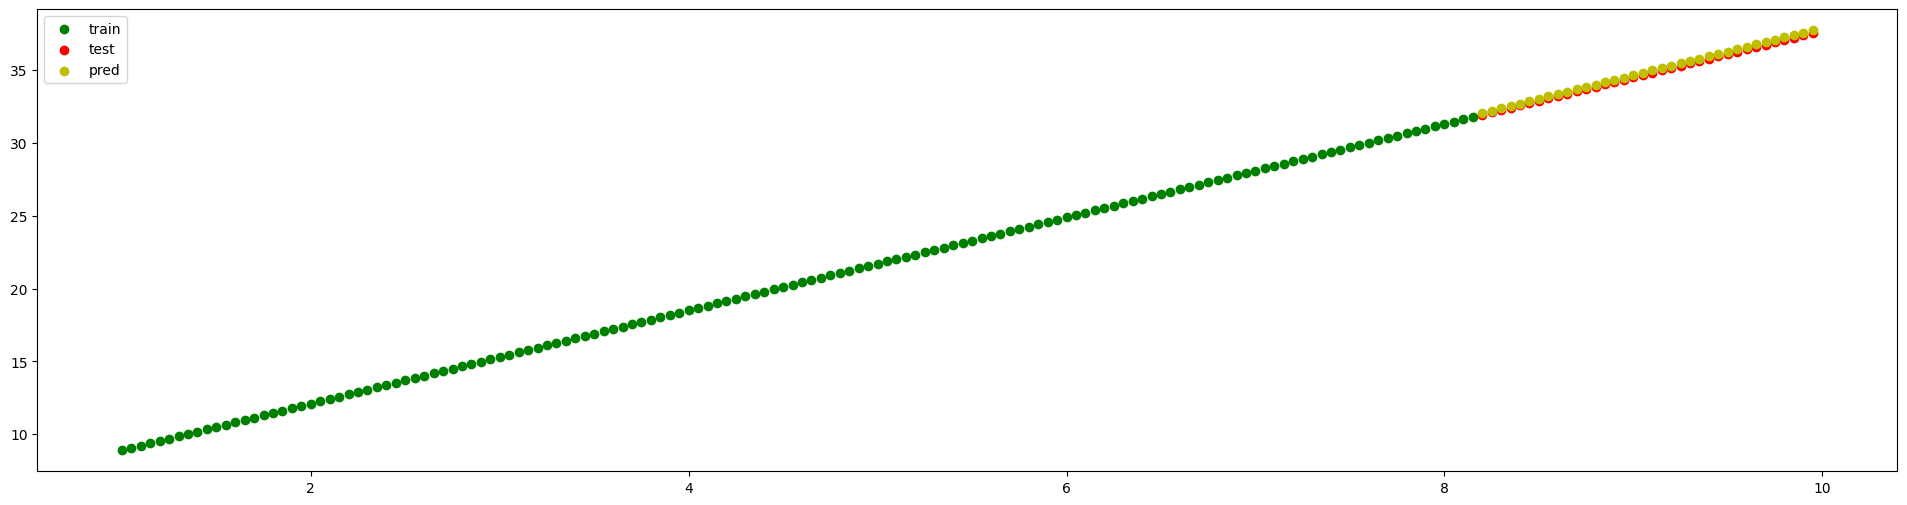

In [86]:
plot(train=(X_train, y_train), test=(X_test, y_test), pred = y_p)

In [87]:
round(Wi.data, 2), round(bi.data, 2), m, b # autograd for scalar linear regression works good :)

(3.24, 5.46, 3.2, 5.7)

In [88]:
import torch

In [89]:
# understanding broadcasting to try 2-D tensor manipulation and arthematics

# rules:
# starting from the trailing dimension for 2 matrices or tensors
# the dimensions should either match, be 0 or be 1

# for example

t_ones = torch.ones(3) # this is a (3, ) vector
print(t_ones, t_ones.shape) # verifying

t_rand = torch.rand((2, 3)) # this is a (2, 3) tensor
print(t_rand, t_rand.shape)

# here:
# (3, 1) -> this will become 2, 3
# (2, 3)

tensor([1., 1., 1.]) torch.Size([3])
tensor([[0.5905, 0.1796, 0.4750],
        [0.9447, 0.2060, 0.8655]]) torch.Size([2, 3])


In [90]:
# trying addition
t_ones + t_rand

tensor([[1.5905, 1.1796, 1.4750],
        [1.9447, 1.2060, 1.8655]])

In [ ]:
# rebuild value class for tensor specific operations.